**Load Data**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sn


# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

GIVE_ALL = False
DAY_TIME = False
USE_MIXED = False
USE_PRESSURE_TEMP = True
USE_SPECIFIC_CLOUDS = True
LOW_VIS_FRAC = True
low_vis_frac = 0.45
low_vis_threshold = 1000 #50000
cloud_types = [1,3,4] #0,1,2 ::: 0, 3, 4
noise_level = 0.01 # fraction of max - min
dnn_batch_size = 64

if USE_MIXED:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_mixed.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_mixed.dat', 'fog_data2_ir_water.dat']
else:
    filenames_vis = ['fog_data2_vis_clear.dat', 'fog_data2_vis_ice.dat', 'fog_data2_vis_water.dat']
    filenames_ir = ['fog_data2_ir_clear.dat', 'fog_data2_ir_ice.dat', 'fog_data2_ir_water.dat']

target_i = 30 # Visibility index
if USE_PRESSURE_TEMP:
    features_i = np.concatenate(([41], np.arange(4, 17), np.arange(20, 30), np.arange(31,36))) # 13 ir bands, 10 vis bands, 3 angles, pressure, temp
else:
    features_i = np.concatenate(([41], np.arange(4, 17), np.arange(20, 30), np.arange(31,34)))

if GIVE_ALL:
   features_i = np.concatenate((np.arange(0, 30), (np.arange(31, 42))))

# Combine .dat files into one numpy array
data_ir_vis = []
for file_ir, file_vis in zip(filenames_ir, filenames_vis):
  raw_data_ir = pd.read_csv('fog_dataset2/' + file_ir).to_numpy()
  raw_data_vis = pd.read_csv('fog_dataset2/' + file_vis).to_numpy()

  data_ir = np.array([row[0].split() for row in raw_data_ir[25:]])
  data_vis = np.array([row[0].split()[1:] for row in raw_data_vis[41:]])

  if len(data_ir_vis) == 0:
    data_ir_vis = np.hstack([data_ir, data_vis])
  else:
    data_ir_vis = np.vstack([data_ir_vis, np.hstack([data_ir, data_vis])])

data_ir_vis_str = data_ir_vis.copy()

# Remove surface description to convert to float
data_ir_vis = data_ir_vis[:,:-1] 
data_ir_vis = data_ir_vis.astype(np.float32)

index_col = np.arange(len(data_ir_vis)).reshape(-1, 1)  
data_ir_vis = np.hstack([data_ir_vis, index_col], dtype=np.float32)


# Some data points contains nan. Not sure why. Band 32 culprit, 8th feature
nan_i = np.where(np.isnan(data_ir_vis))[0]
data_ir_vis = np.delete(data_ir_vis, nan_i, axis=0)

# Cloud type index = 37
if USE_SPECIFIC_CLOUDS:
   data_ir_vis = data_ir_vis[np.isin(data_ir_vis[:, 37], cloud_types)]

if DAY_TIME:
   #data_ir_vis = data_ir_vis[np.where(np.abs(data_ir_vis[:, 33] - 90) < 30)[0]]
   data_ir_vis = data_ir_vis[np.where(data_ir_vis[:, 32] < 30)[0]]



X = data_ir_vis[:, features_i]
y = data_ir_vis[:,target_i]

noise_std_devs = np.zeros(features_i.shape)

for i, feature_i in enumerate(features_i):
    noise_std = (np.max(data_ir_vis[:,feature_i]) - np.min(data_ir_vis[:,feature_i])) * noise_level # 1% of mean or max??
    noise_std_devs[i] = noise_std

# Scaling features and noise standard deviations
feature_scaler = StandardScaler()
X_scaled = feature_scaler.fit_transform(X)
noise_stds_scaled = np.divide(noise_std_devs, feature_scaler.scale_)

# Scaling target
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1, 1))


# First split: Separate out a test set (5% of the original dataset)
X_temp, X_test, y_temp, y_test_reg = train_test_split(X_scaled, y_scaled, test_size=(1/20))


if LOW_VIS_FRAC:
    low_vis_i = np.where(target_scaler.inverse_transform(y_temp) < low_vis_threshold)[0]
    high_vis_i = np.where(target_scaler.inverse_transform(y_temp) >= low_vis_threshold)[0]

    n_high_vis = int(len(low_vis_i) / low_vis_frac * (1 - low_vis_frac))
    print(f'real frac: {len(low_vis_i)/len(y_scaled)}')
    if n_high_vis > len(high_vis_i):
        n_high_vis = len(high_vis_i)
        n_low_vis = int(low_vis_frac * n_high_vis)
        r_low_vis_i = np.random.choice(low_vis_i, n_low_vis, replace=False)
        low_vis_i = r_low_vis_i
    print(f'n_low_vis: {len(low_vis_i)}. n_high_vis: {n_high_vis}')
    r_high_vis_i = np.random.choice(high_vis_i, n_high_vis, replace=False)
    X_temp = np.vstack([X_temp[low_vis_i], X_temp[r_high_vis_i]])
    y_temp = np.vstack([y_temp[low_vis_i], y_temp[r_high_vis_i]])


# Second split: Split the remaining data into training and validation sets
X_train, X_val, y_train_reg, y_val_reg = train_test_split(X_temp, y_temp, test_size=(1/19))

# Create noisy data
X_train_noisy = X_train + np.multiply(np.random.normal(0, 1, X_train.shape), noise_stds_scaled)
X_val_noisy = X_val + np.multiply(np.random.normal(0, 1, X_val.shape), noise_stds_scaled)
X_test_noisy = X_test + np.multiply(np.random.normal(0, 1, X_test.shape), noise_stds_scaled)

# Create class labels
y_train_class = np.where(target_scaler.inverse_transform(y_train_reg) < low_vis_threshold, 1, 0)
y_val_class = np.where(target_scaler.inverse_transform(y_val_reg) < low_vis_threshold, 1, 0)
y_test_class = np.where(target_scaler.inverse_transform(y_test_reg) < low_vis_threshold, 1, 0)


# Create training data for DNN that adds noise to batches
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_reg)).batch(batch_size=dnn_batch_size)
training_data_class = tf.data.Dataset.from_tensor_slices((X_train, y_train_class)).batch(batch_size=dnn_batch_size)

def noise_map(features, labels):
    noise = tf.random.normal(shape=tf.shape(features))
    noise = noise * noise_stds_scaled
    noisy_features = features + noise
    return noisy_features, labels

training_data = training_data.map(noise_map)
training_data_class = training_data_class.map(noise_map)

2024-04-12 11:57:22.103519: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 11:57:22.136866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 11:57:22.136887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 11:57:22.137776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 11:57:22.143397: I tensorflow/core/platform/cpu_feature_guar

real frac: 0.1563156782723765
n_low_vis: 14057. n_high_vis: 17180


2024-04-12 11:57:42.508935: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 11:57:42.542386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 11:57:42.546170: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

**Classification All Clouds**

XGBoost (Gradient boosted decision trees)

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      3772
           1       0.36      0.74      0.49       725

    accuracy                           0.75      4497
   macro avg       0.65      0.74      0.66      4497
weighted avg       0.84      0.75      0.78      4497



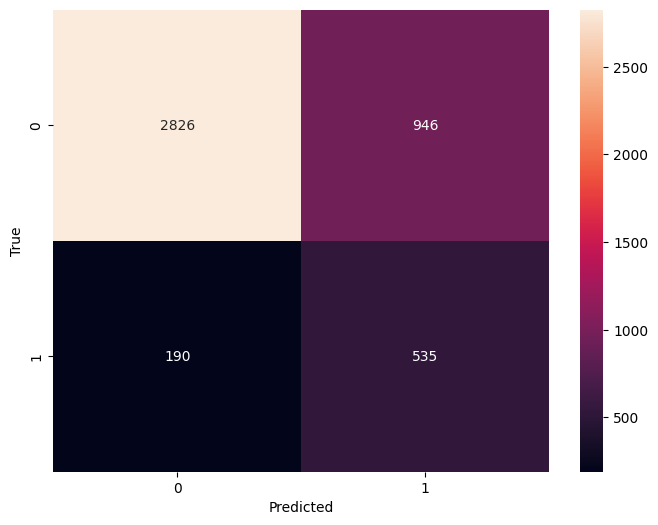

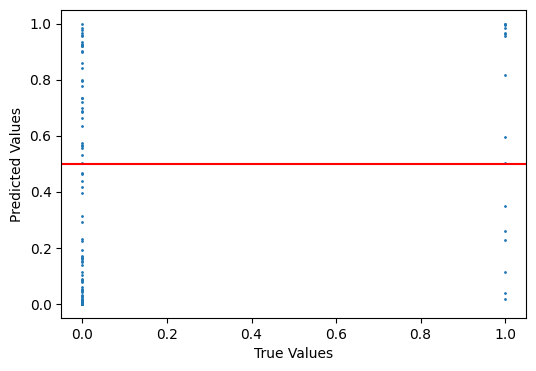

In [4]:
import xgboost as xgb

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test, label=y_test_class)

params = {
    'objective': 'binary:logistic',  
    'max_depth': 20,
    'learning_rate': 0.05,
    #'scale_pos_weight': neg_to_pos_ratio,

}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred = model.predict(dtest)
y_pred_class = (y_pred > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_class[:100], y_pred[:100], s=1)
plt.axhline(y=0.5, color='r', linestyle='-') 
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [42]:

# Print feature importance (using the 'weight' metric)
print(model.get_fscore()) 

# Access feature importances with other metrics
print(model.get_score(importance_type='gain'))
print(model.get_score(importance_type='cover'))


{'f0': 38912.0, 'f1': 19979.0, 'f2': 20407.0, 'f3': 18262.0, 'f4': 30963.0, 'f5': 22860.0, 'f6': 18731.0, 'f7': 22190.0, 'f8': 19510.0, 'f9': 19857.0, 'f10': 18254.0, 'f11': 18571.0, 'f12': 18552.0, 'f13': 28658.0, 'f14': 25064.0, 'f15': 21687.0, 'f16': 22603.0, 'f17': 20666.0, 'f18': 24375.0, 'f19': 24408.0, 'f20': 24903.0, 'f21': 24784.0, 'f22': 19844.0, 'f23': 35789.0, 'f24': 38031.0, 'f25': 29997.0, 'f26': 38206.0, 'f27': 31201.0, 'f28': 38813.0}
{'f0': 7.835193634033203, 'f1': 2.86991286277771, 'f2': 0.9048166871070862, 'f3': 1.0367388725280762, 'f4': 0.7892154455184937, 'f5': 0.8576876521110535, 'f6': 1.1941338777542114, 'f7': 1.0408802032470703, 'f8': 1.329665184020996, 'f9': 2.8919119834899902, 'f10': 1.1104698181152344, 'f11': 1.0036343336105347, 'f12': 0.8471232056617737, 'f13': 0.7642878890037537, 'f14': 0.968000054359436, 'f15': 0.7444195747375488, 'f16': 0.9659180045127869, 'f17': 0.9042354226112366, 'f18': 0.9228959083557129, 'f19': 1.006240963935852, 'f20': 1.47046828269

In [3]:
def calculate_surface_height(P_hPa):
    P = 100 * P_hPa
    P_b = 101325
    T_b = 288.15
    L_b = -0.0065
    h_b = 11000
    R = 8.31432
    g = 9.80665
    M = 0.0289644
    h = h_b + (T_b / L_b) * ((P / P_b)**(-R*L_b/(g * M)) - 1)
    return h

In [12]:
false_pos_indices = np.where((y_pred_class == 1) & (y_test_class.flatten() == 0))[0]
false_neg_indices = np.where((y_pred_class == 0) & (y_test_class.flatten() == 1))[0]

test_set_IDs = np.round(feature_scaler.inverse_transform(X_test)).astype(int)
test_set_data = data_ir_vis[np.isin(data_ir_vis[:, 41], test_set_IDs)]

false_pos_IDs =  np.round(feature_scaler.inverse_transform(X_test)[false_pos_indices, 0]).astype(int)
false_neg_IDs =  np.round(feature_scaler.inverse_transform(X_test)[false_neg_indices, 0]).astype(int)

false_pos_data = data_ir_vis[np.isin(data_ir_vis[:, 41], false_pos_IDs)]
false_neg_data = data_ir_vis[np.isin(data_ir_vis[:, 41], false_neg_IDs)]


plot_features = [34, 35, 30, 40]

false_pos_plottables = false_pos_data[:, plot_features]
false_neg_plottables = false_neg_data[:, plot_features]
test_set_plottables = test_set_data[:, plot_features]

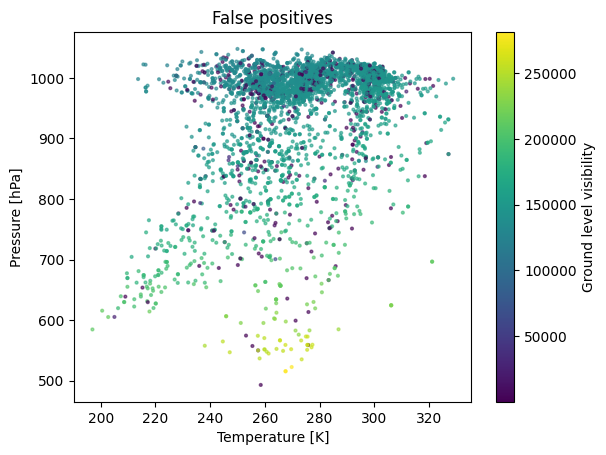

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ... (Your code for creating 'false_pos_plottables' and 'test_set_plottables')

fig, ax = plt.subplots()

# Scatter plot with the 'c' argument 
scatter = ax.scatter(false_pos_plottables[:,0], false_pos_plottables[:,1], 
                     c=false_pos_plottables[:,2], s=4, alpha=0.6) 

# ... (Your code for axis limits)

# Custom colorbar setup
vmin = test_set_plottables[:,2].min() 
vmax = test_set_plottables[:,2].max() 
cmap = plt.cm.viridis 
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Associate the colormap with the scatter plot
scatter.set_cmap(cmap)

# Create the colorbar 
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        ax=ax) 
colorbar.set_label('Ground level visibility')

plt.title('False positives')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.show()


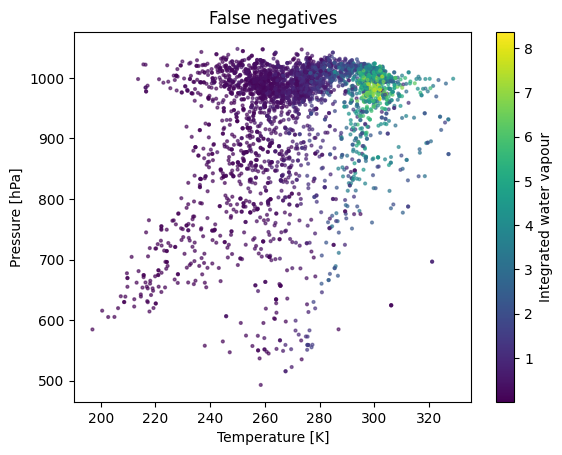

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ... (Your code for creating 'false_pos_plottables' and 'test_set_plottables')

fig, ax = plt.subplots()

# Scatter plot with the 'c' argument 
scatter = ax.scatter(false_pos_plottables[:,0], false_pos_plottables[:,1], 
                     c=false_pos_plottables[:,3], s=4, alpha=0.6) 

# ... (Your code for axis limits)

# Custom colorbar setup
vmin = test_set_plottables[:,3].min() 
vmax = test_set_plottables[:,3].max() 
cmap = plt.cm.viridis 
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Associate the colormap with the scatter plot
scatter.set_cmap(cmap)

# Create the colorbar 
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        ax=ax) 
colorbar.set_label('Integrated water vapour')

plt.title('False negatives')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.show()


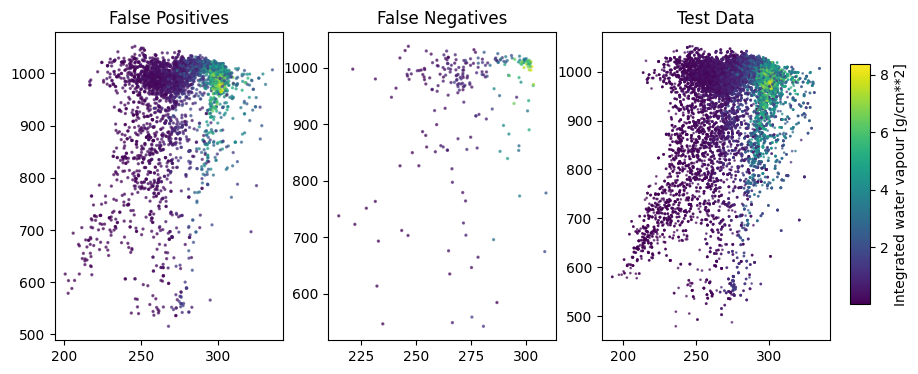

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Figure with a constrained layout for better space management
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), constrained_layout=False)

n_plot_points = len(false_neg_plottables)

# --- Plot 1: False Positives ---
vmin = test_set_plottables[:, 3].min()
vmax = test_set_plottables[:, 3].max()
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

scatter1 = ax1.scatter(false_pos_plottables[:,0], false_pos_plottables[:,1], 
                       c=false_pos_plottables[:,3], s=2, alpha=0.6)
scatter1.set_cmap(cmap)

# Create the colorbar outside the main axes
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust coordinates for placement
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
colorbar.set_label('Integrated water vapour [g/cm**2]')

ax1.set_title('False Positives') 

# --- Plot 2: False Negatives ---
scatter2 = ax2.scatter(false_neg_plottables[:,0], false_neg_plottables[:,1], 
                       c=false_neg_plottables[:,3], s=2, alpha=0.6)
scatter2.set_cmap(cmap)
ax2.set_title('False Negatives')

# --- Plot 3: Test Data --- 
scatter3 = ax3.scatter(test_set_plottables[:,0], test_set_plottables[:,1], 
                       c=test_set_plottables[:,3], s=1, alpha=0.6)
scatter3.set_cmap(cmap)
ax3.set_title('Test Data')

# Adjust layout and show the plots
#plt.tight_layout() 
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Figure with a constrained layout for better space management
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), constrained_layout=False)

n_plot_points = len(false_neg_plottables)

# --- Plot 1: False Positives ---
vmin = test_set_plottables[:, 2].min()
vmax = test_set_plottables[:, 2].max()
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

scatter1 = ax1.scatter(false_pos_plottables[:,0], false_pos_plottables[:,1], 
                       c=false_pos_plottables[:,2], s=2, alpha=0.6)
scatter1.set_cmap(cmap)

# Create the colorbar outside the main axes
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust coordinates for placement
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
colorbar.set_label('Ground level visibility')

ax1.set_title('False Positives') 

# --- Plot 2: False Negatives ---
scatter2 = ax2.scatter(false_neg_plottables[:,0], false_neg_plottables[:,1], 
                       c=false_neg_plottables[:,2], s=2, alpha=0.6)
scatter2.set_cmap(cmap)
ax2.set_title('False Negatives')

# --- Plot 3: Test Data --- 
scatter3 = ax3.scatter(test_set_plottables[:,0], test_set_plottables[:,1], 
                       c=test_set_plottables[:,2], s=1, alpha=0.6)
scatter3.set_cmap(cmap)
ax3.set_title('Test Data')

# Adjust layout and show the plots
#plt.tight_layout() 
plt.show()


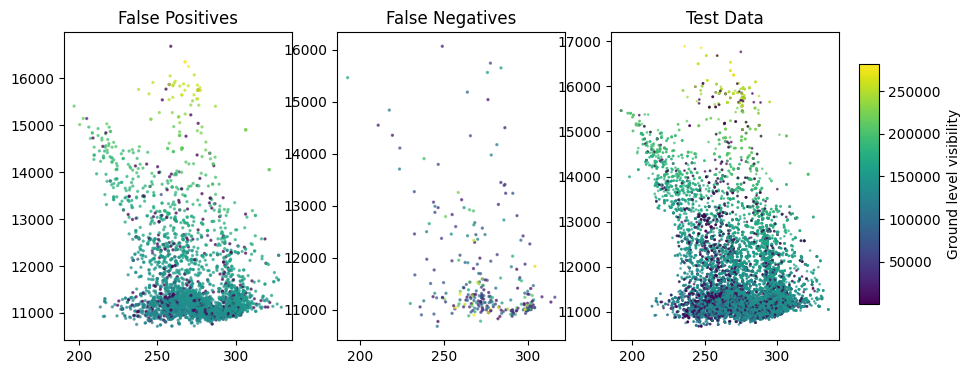

In [30]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Figure with a constrained layout for better space management
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), constrained_layout=False)  

# --- Plot 1: False Positives ---
vmin = test_set_plottables[:, 2].min()
vmax = test_set_plottables[:, 2].max()
cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

scatter1 = ax1.scatter(false_pos_plottables[:,0], false_pos_plottables[:,-1], 
                       c=false_pos_plottables[:,2], s=2, alpha=0.6)
scatter1.set_cmap(cmap)

# Create the colorbar outside the main axes
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust coordinates for placement
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
colorbar.set_label('Ground level visibility')

ax1.set_title('False Positives') 

# --- Plot 2: False Negatives ---
scatter2 = ax2.scatter(false_neg_plottables[:,0], false_neg_plottables[:,-1], 
                       c=false_neg_plottables[:,2], s=2, alpha=0.6)
scatter2.set_cmap(cmap)
ax2.set_title('False Negatives')

# --- Plot 3: Test Data --- 
scatter3 = ax3.scatter(test_set_plottables[:,0], test_set_plottables[:,-1], 
                       c=test_set_plottables[:,2], s=1, alpha=0.6)
scatter3.set_cmap(cmap)
ax3.set_title('Test Data')

# Adjust layout and show the plots
#plt.tight_layout() 
plt.show()


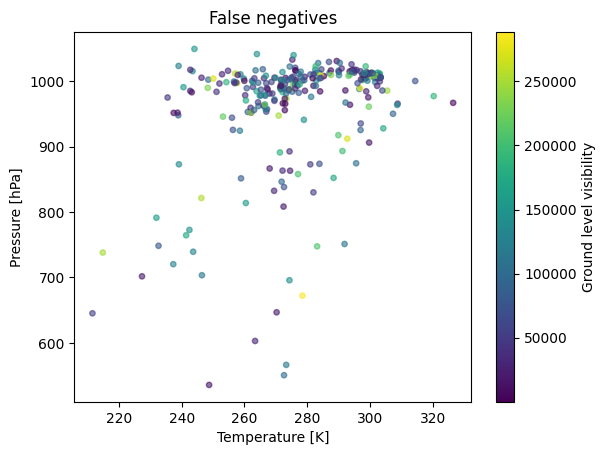

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# ... (Your code for creating 'false_pos_plottables' and 'test_set_plottables')

fig, ax = plt.subplots()

# Scatter plot with the 'c' argument 
scatter = ax.scatter(false_neg_plottables[:,0], false_neg_plottables[:,1], 
                     c=false_neg_plottables[:,2], s=15, alpha=0.6) 

# ... (Your code for axis limits)

# Custom colorbar setup
vmin = test_set_plottables[:,2].min() 
vmax = test_set_plottables[:,2].max() 
cmap = plt.cm.viridis 
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Associate the colormap with the scatter plot
scatter.set_cmap(cmap)

# Create the colorbar 
colorbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                        ax=ax) 
colorbar.set_label('Ground level visibility')

plt.title('False negatives')
plt.xlabel('Temperature [K]')
plt.ylabel('Pressure [hPa]')
plt.show()


Cloud: Clear
Prevalence: 35.75%
False negative rate: 0%
Cloud: Stratus Continental
Prevalence: 6.6%
False negative rate: 14.51%
Cloud: Stratus Maritime
Prevalence: 6.25%
False negative rate: 15.02%
Cloud: Cumulus Continental Clean
Prevalence: 6.35%
False negative rate: 10.79%
Cloud: Cumulus Continental Polluted
Prevalence: 6.37%
False negative rate: 12.94%
Cloud: Cumulus Maritime
Prevalence: 6.33%
False negative rate: 12.97%
Cloud: Cirrus
Prevalence: 32.36%
False negative rate: 9.06%


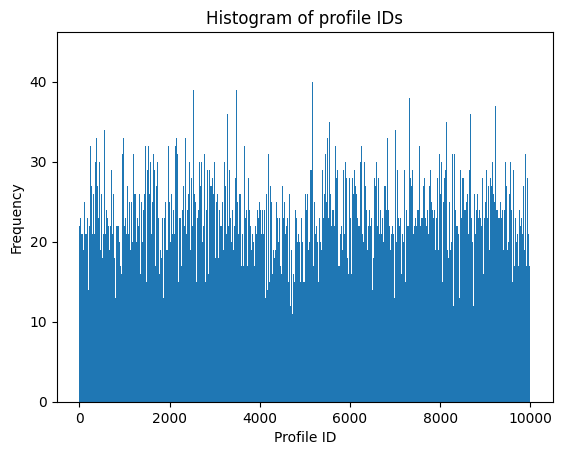

In [31]:
# Cloud type index = 37
# clear = 0
# stratus continental = 1
# stratus maritime = 2
# cumulus continental clean = 3
# cumulus continental polluted = 4
# cumulus maritime = 5
# cirrus = 6
# cirrus + water clouds (mixed) >= 7

cloud_names = ['Clear', 'Stratus Continental', 'Stratus Maritime', 'Cumulus Continental Clean', 'Cumulus Continental Polluted',
               'Cumulus Maritime', 'Cirrus']

for cloud in range(0,7):
    n_cloud_instances = len(np.where(false_neg_data[:,37] == cloud)[0])
    n_clouds_total = len(np.where((test_set_data[:,37] == cloud) & (test_set_data[:,30] < low_vis_threshold))[0])
    prevalence = round(100* len(np.where((test_set_data[:,37] == cloud))[0]) / len(test_set_data), 2)
    if n_clouds_total == 0 and n_cloud_instances == 0:
        false_rate = 0
    else:
        false_rate = round(100 * n_cloud_instances / n_clouds_total, 2)
    print(f'Cloud: {cloud_names[cloud]}')
    print(f'Prevalence: {prevalence}%')
    print(f'False negative rate: {false_rate}%')

plt.hist(test_set_data[:,38].astype(int), bins=1000)
plt.xlabel("Profile ID")
plt.ylabel("Frequency")
plt.title("Histogram of profile IDs")
plt.show()


Deep Neural Network

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-03-25 10:13:07.804549: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb6100036d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-25 10:13:07.804601: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-03-25 10:13:07.867313: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-25 10:13:08.193546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1711361591.441

704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


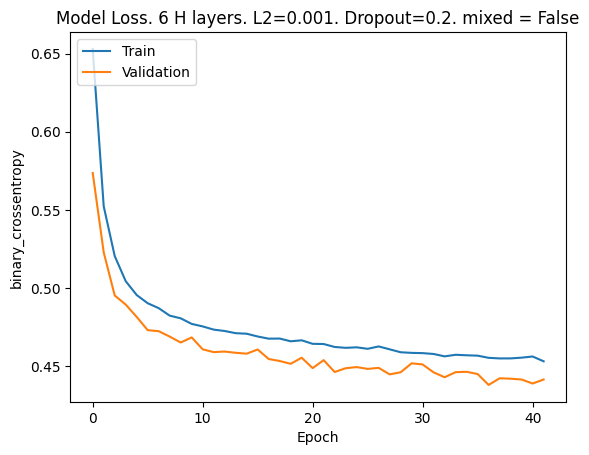

              precision    recall  f1-score   support

           0       0.98      0.76      0.86     20421
           1       0.27      0.88      0.41      2078

    accuracy                           0.77     22499
   macro avg       0.63      0.82      0.64     22499
weighted avg       0.92      0.77      0.82     22499



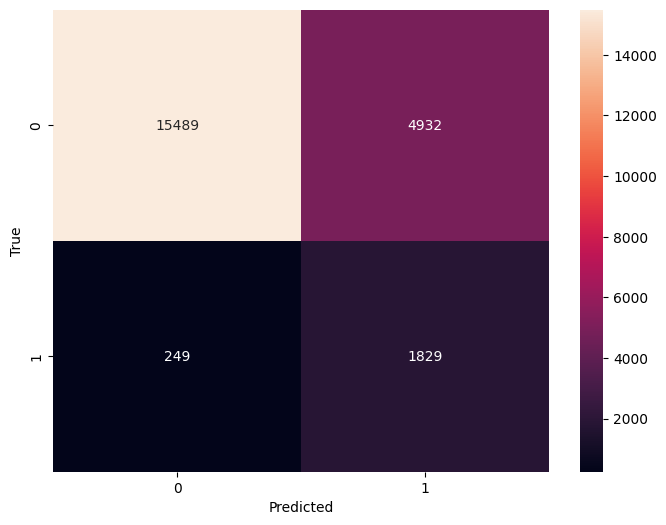

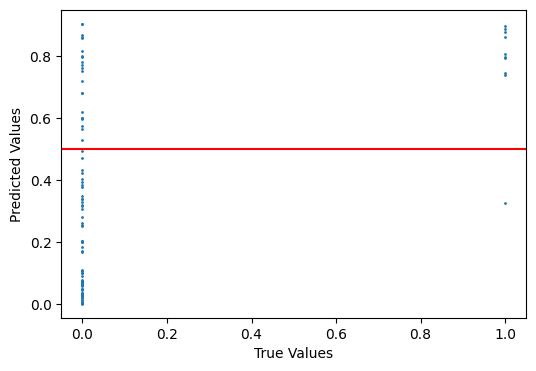

In [5]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 #loss = BinaryFocalCrossentropy(alpha=0.50, gamma=2, apply_class_balancing=False),
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = ff_model.fit(training_data_class, epochs = 100, validation_data=(X_val_noisy, y_val_class), verbose=0, callbacks=[early_stopping])


y_pred = ff_model.predict(X_test)

y_pred_class = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_class)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_class))
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_class[:100], y_pred[:100], s=1)
plt.axhline(y=0.5, color='r', linestyle='-') 
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

**Classification on single cloud type (only cirrus clouds, clear data not included!)**

XGBoost

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      6566
           1       0.41      0.82      0.55       933

    accuracy                           0.83      7499
   macro avg       0.69      0.83      0.72      7499
weighted avg       0.90      0.83      0.85      7499



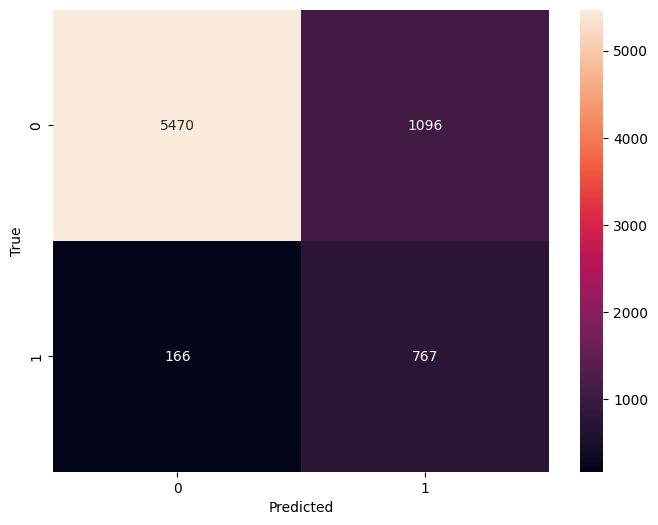

In [20]:
import xgboost as xgb

neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)

dtrain = xgb.DMatrix(X_train_noisy, label=y_train_class)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_class)

params = {
    'objective': 'binary:logistic',  
    'max_depth': 16,
    'learning_rate': 0.05,
    #'scale_pos_weight': neg_to_pos_ratio,

}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
predictions_1 = model.predict(dtest)
y_pred_class = (predictions_1 > 0.5 ).astype(int) 

print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize=(8,6))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Deep Neural Network

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1711118272.485713 1364871 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


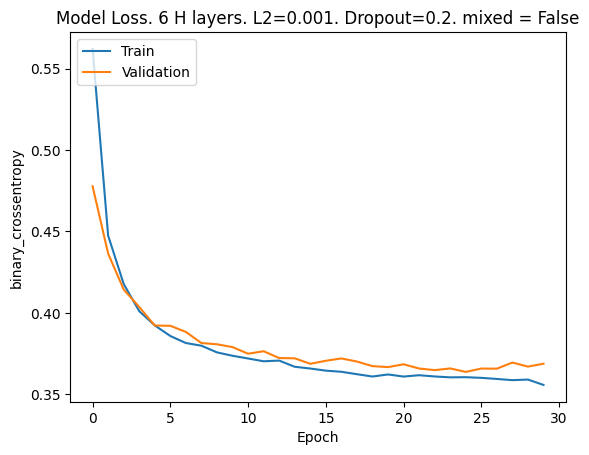

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      6566
           1       0.49      0.77      0.60       933

    accuracy                           0.87      7499
   macro avg       0.73      0.83      0.76      7499
weighted avg       0.91      0.87      0.88      7499



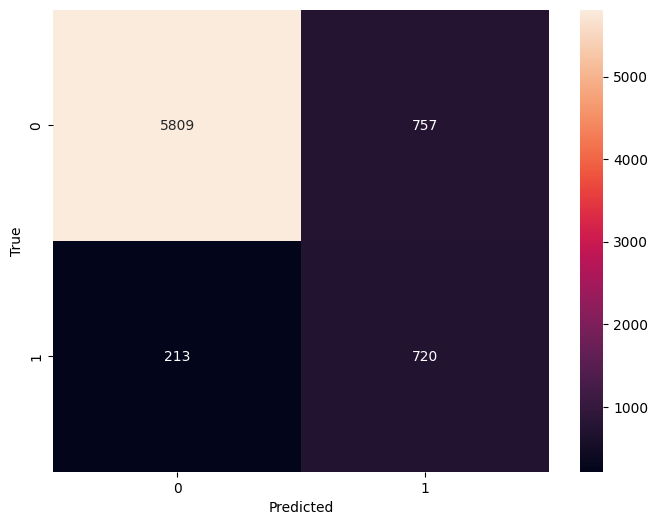

In [21]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from keras.losses import BinaryFocalCrossentropy


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),
    
    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='sigmoid') 
])

# Compile the model for classification
ff_model.compile(optimizer='adam',
                 #loss = BinaryFocalCrossentropy(alpha=0.50, gamma=2, apply_class_balancing=False),
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history = ff_model.fit(training_data_class, epochs = 100, validation_data=(X_val_noisy, y_val_class), verbose=0, callbacks=[early_stopping])


y_pred = ff_model.predict(X_test)

y_pred_class = (y_pred > 0.5 ).astype(int) 
cm = confusion_matrix(y_test_class, y_pred_class)


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('binary_crossentropy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print(classification_report(y_test_class, y_pred_class))
plt.figure(figsize=(8,6)) 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Regression models on all cloud types**

XGBoost

MSE: 1.0529242753982544


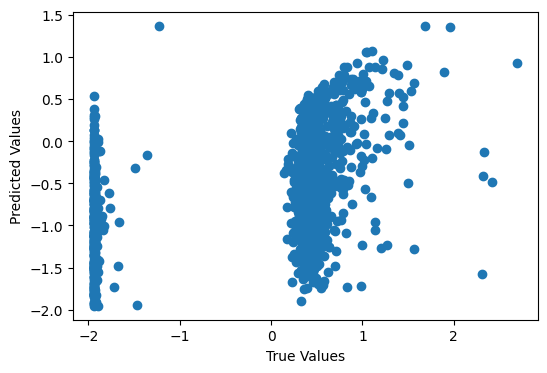

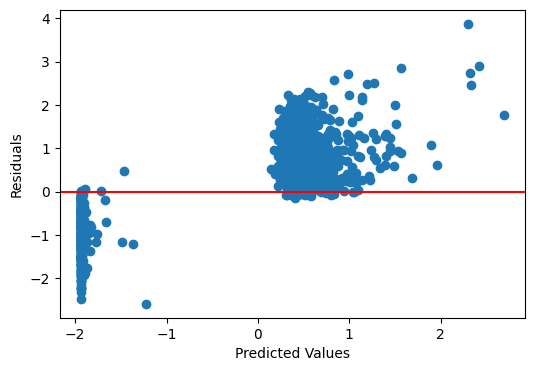

In [6]:
import xgboost as xgb
from sklearn.metrics import classification_report

#neg_to_pos_ratio = (len(y_train_class) - np.sum(y_train_class)) / np.sum(y_train_class)


dtrain = xgb.DMatrix(X_train_noisy, label=y_train_reg)
dtest = xgb.DMatrix(X_test_noisy, label=y_test_reg)

params = {
    'objective': 'reg:squarederror',  # For regression
    'max_depth': 16,  # Maximum tree depth
    'learning_rate': 0.05,
    'subsample': 0.8,
    #'scale_pos_weight': neg_to_pos_ratio,
   # ... other parameters (Refer to XGBoost documentation)
}
num_rounds = 1000  # Number of boosting rounds
model = xgb.train(params, dtrain, num_rounds)
y_pred_reg = model.predict(dtest)
residuals = y_test_reg.ravel() - y_pred_reg


print(f'MSE: {mean_squared_error(y_test_reg.ravel(), y_pred_reg)}')

# Scatter Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, y_pred_reg)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test_reg, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

Deep Neural Network

/home/edgelab/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-04-03 11:37:49.818057: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4e44013ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 11:37:49.818147: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-04-03 11:37:49.992148: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 11:37:50.553751: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1712144274.154

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean squared error: 1.023818850517273


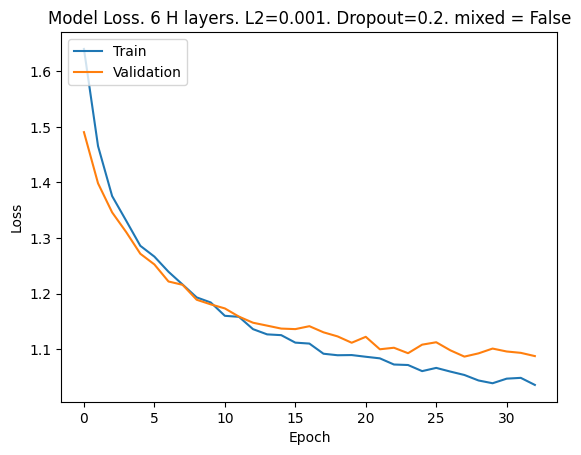

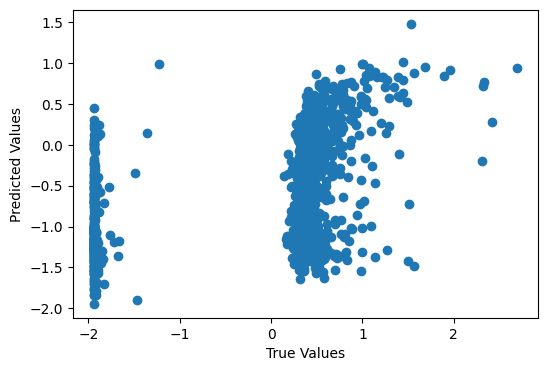

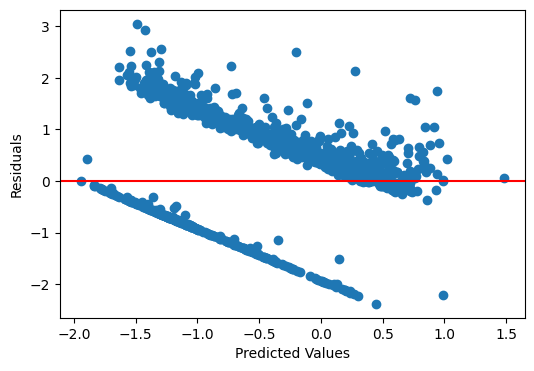

In [7]:
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping


# Define the model
ff_model = tf.keras.Sequential([
    # Input layer
    layers.Dense(len(features_i), activation='relu', input_shape=(len(features_i),)),

    # Hidden layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # layers.Dropout(0.2),
    # layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),

    # Output layer
    layers.Dense(1, activation='linear')
])

# Compile the model for regression
ff_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

# tf.optimizers.Adam(learning_rate=1e-3)
#model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#history = ff_model.fit(X_train, y_train, epochs = 500, batch_size = 64, validation_data=(X_val, y_val))
history = ff_model.fit(training_data, epochs = 100, validation_data=(X_val_noisy, y_val_reg), verbose=0, callbacks=[early_stopping])
#history = ff_model.fit(X_low_vis_train, y_low_vis_train_scaled, epochs = 50, validation_data=(X_low_vis_val, y_low_vis_val_scaled))


# y_pred = ff_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# residuals = y_test - y_pred
# print(f'Mean squared error: {mse}')

y_pred = ff_model.predict(X_test_noisy)
#mse = mean_squared_error(y_low_vis_test_scaled, y_pred)
mse = mean_squared_error(y_test_reg, y_pred)

residuals = y_test_reg - y_pred 
print(f'Mean squared error: {mse}')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss. 6 H layers. L2=0.001. Dropout=0.2. mixed = {USE_MIXED}')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 4))
#plt.scatter(y_low_vis_test_scaled, y_pred)
plt.scatter(y_test_reg, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

QRNN

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_12               │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_13               │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_14               │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_15               │ (None, 64)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,985 (58.54 KB)

 Trainable params: 14,985 (58.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.9495 - val_loss: 0.6974
Epoch 2/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6742 - val_loss: 0.5589
Epoch 3/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5502 - val_loss: 0.4769
Epoch 4/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4705 - val_loss: 0.4253
Epoch 5/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4261 - val_loss: 0.3888
Epoch 6/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3914 - val_loss: 0.3602
Epoch 7/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3698 - val_loss: 0.3442
Epoch 8/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3555 - val_loss: 0.3326
Epoch 9/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3424 - val_loss: 0.3239
Epoch 10/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3319 - val_loss: 0.3213
Epoch 11/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3252 - val_loss: 0.3154
Epoch 12/40
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 

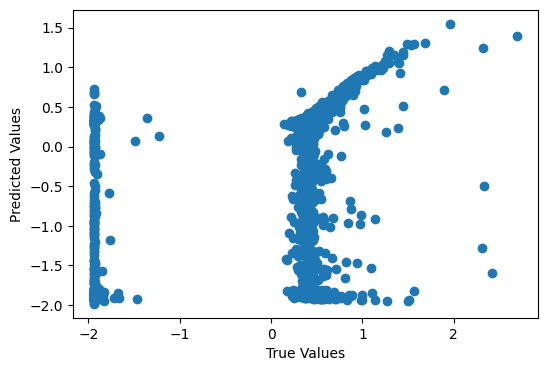

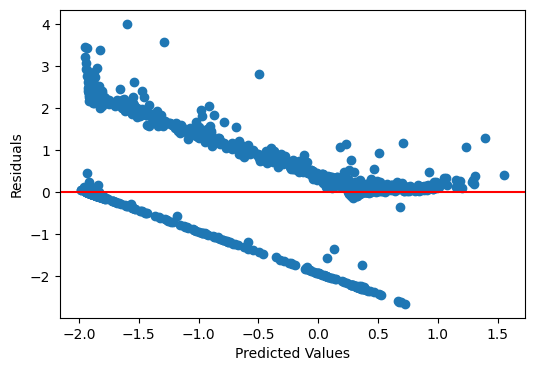

In [18]:
from qrnn import get_model, qloss
from keras.callbacks import *
import numpy as np


# Parameters
input_dim = len(features_i)
num_hidden_layers = 4
num_units = [64, 64, 64, 64]
act = ['relu', 'relu', 'relu', 'relu']
dropout = [0.1, 0.1, 0.1, 0.1]
gauss_std = [0.0, 0.0, 0.0, 0.0]
num_quantiles = 9

# Get model
model = get_model(input_dim, num_units, act, dropout, gauss_std, num_hidden_layers, num_quantiles)
print(model.summary())

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss=lambda y_t, y_p: qloss(y_true=y_t, y_pred=y_p, n_q=num_quantiles), 
              optimizer='adam')
model.fit(x=X_train_noisy, y=y_train_reg, 
          epochs=40, 
          validation_split=0.1, 
          batch_size=64, 
          shuffle=True, 
          callbacks=[early_stopping]
         )

y_pred = model.predict(X_test_noisy)

mid_quantile = y_pred[:,4]
residuals = y_test_reg.ravel() - mid_quantile 

print(residuals.shape)


print(mean_squared_error(y_test_reg, y_pred[:,4]))

# Scatter Plot
plt.figure(figsize=(6, 4))
#plt.scatter(y_low_vis_test_scaled, y_pred)
plt.scatter(y_test_reg, mid_quantile)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

# Residual Plot
plt.figure(figsize=(6, 4))
plt.scatter(mid_quantile, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-') 
plt.show()

In [17]:
print(y_test_reg.shape)
print(mid_quantile.shape)

print((y_test_reg.ravel() - mid_quantile).shape)

(1505, 1)
(1505,)
(1505,)
